***Import Modules***

In [1]:
import pandas as pd
import numpy as np
from pyts.decomposition import SSA
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from statsmodels.tsa.api import ExponentialSmoothing
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve
from sklearn.utils.fixes import signature
from sklearn.metrics import average_precision_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from scipy import stats
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import itertools
import os

***Load in data for various companies***

In [2]:
#Companies: AAPL GOOG, FB, IBM, BB, MSFT, SAMSUNG
dataframes = [pd.read_csv('AAPL10YEAR.csv'), pd.read_csv('GOOG10YEAR.csv'), pd.read_csv('FB10YEAR.csv'), pd.read_csv('IBM10YEAR.csv'), pd.read_csv('BB10YEAR.csv'), pd.read_csv('MSFT10YEAR.csv'), pd.read_csv('SAMSUNG10YEAR.csv')]
data = [df.values for df in dataframes]


***An alternate approach: use many lag variables and reduce dimensions with PCA***

In [3]:
#Short-term trading:
#DAYS_AHEAD = 7
#FEATURES = 10
#MEAN_LENGTH = 2
#JUMP = 1
#n_components = 10

#Mid-term trading:
#DAYS_AHEAD = 90
#FEATURES = 90
#MEAN_LENGTH = 10
#JUMP = 3
#n_components = 10

DAYS_AHEAD = 7
FEATURES = 10
MEAN_LENGTH = 2
JUMP = 1

complete_data = np.array([]).reshape((0, FEATURES // JUMP))
labels = np.array([])

company_indices = {'aapl':0, 'goog':1, 'fb':2, 'ibm':3, 'bb':4, 'msft':5, 'samsung':6}
scalers = []

#First process the first 80% of each company's data. This will be the train set.
for company in data:
    length = company.shape[0] - DAYS_AHEAD - FEATURES - MEAN_LENGTH
    closes = (company.T)[4]
    
    #Smooth using running mean   
    closes = np.convolve(closes, np.ones((MEAN_LENGTH,))/MEAN_LENGTH, mode='valid')
    
    company_data = []
    for i in range(FEATURES+MEAN_LENGTH, int(0.8*length)+FEATURES):
        company_data.append(closes[i - FEATURES : i : JUMP])
    company_data = np.array(company_data)
    scaler = StandardScaler()
    company_data = scaler.fit_transform(company_data.astype(np.float))
    complete_data = np.vstack((complete_data, company_data))
    scalers.append(scaler)
    
    directions = []
    for i in range(FEATURES+MEAN_LENGTH, int(0.8*length)+FEATURES):
        diff = closes[i+DAYS_AHEAD] - closes[i]
        if diff > 0:
            directions.append('up') #increase in price
        else:
            directions.append('down') #decrease in price
    directions = np.array(directions)
    
    labels = np.concatenate((labels, directions), axis = None)
    
#Now process the remaining 20% (test data)
for company in data:
    length = company.shape[0] - DAYS_AHEAD - FEATURES - MEAN_LENGTH
    closes = (company.T)[4]
    
    #Smooth using running mean   
    closes = np.convolve(closes, np.ones((MEAN_LENGTH,))/MEAN_LENGTH, mode='valid')
    
    company_data = []
    for i in range(int(0.8*length)+FEATURES, (company.shape[0] - DAYS_AHEAD - MEAN_LENGTH - 1)):
        company_data.append(closes[i - FEATURES : i : JUMP])
    company_data = np.array(company_data)
    scaler = StandardScaler()
    company_data = scaler.fit_transform(company_data.astype(np.float))
    complete_data = np.concatenate((complete_data, company_data))
    
    directions = []
    for i in range(int(0.8*length)+FEATURES, (company.shape[0] - DAYS_AHEAD - MEAN_LENGTH - 1)):
        diff = closes[i+DAYS_AHEAD] - closes[i]
        if diff > 0:
            directions.append('up') #increase in price
        else:
            directions.append('down') #decrease in price
    directions = np.array(directions)
    
    labels = np.concatenate((labels, directions), axis = None)

#Apply PCA
pca = PCA(n_components = 10, random_state = 1729)
transformed_data = pca.fit_transform(complete_data)
print(np.sum(pca.explained_variance_ratio_))

0.9999999999999999


In [4]:
train_xs = transformed_data[:int(0.8*transformed_data.shape[0])]
train_ys = labels[:int(0.8*transformed_data.shape[0])]

test_xs = transformed_data[int(0.8*transformed_data.shape[0]):]
test_ys = labels[int(0.8*transformed_data.shape[0]):]

smote = SMOTE(random_state = 1729)
train_xs, train_ys = smote.fit_resample(train_xs, train_ys)

In [5]:
MODEL = 'SVC'

if MODEL == 'SVC':
    clf = svm.SVC(C = 5, gamma = 'scale', kernel = 'rbf', random_state = 42, probability = True, cache_size = 1000)
elif MODEL == 'GBC':
    clf = GradientBoostingClassifier(learning_rate = 0.01, n_estimators = 1000, random_state = 42)

clf.fit(train_xs, train_ys)


SVC(C=5, cache_size=1000, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False)

***Confusion Matrix and Accuracy***

In [6]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

down pred: 1735 up pred: 1461
down test: 1401 up test: 1795
Out of a total of 3196 samples, 1752 were correct
Normalized confusion matrix
[[0.60385439 0.39614561]
 [0.49526462 0.50473538]]


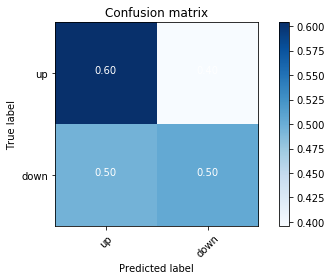

In [7]:
pred = clf.predict(test_xs)
total = test_ys.shape[0]
correct = len([x for x in pred==test_ys if x==True])
print('down pred:', len([i for i in pred if i == 'down']), 'up pred:', len([i for i in pred if i == 'up']))
print('down test:', len([i for i in test_ys if i == 'down']), 'up test:', len([i for i in test_ys if i == 'up']))
print("Out of a total of %d samples, %d were correct" %(total, correct))
cnf_matrix = confusion_matrix(test_ys, pred)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['up', 'down'], normalize=True)

***Precision Recall Curve***

Average precision-recall score: 0.61


Text(0.5,1,'2-class Precision-Recall curve: AP=0.61')

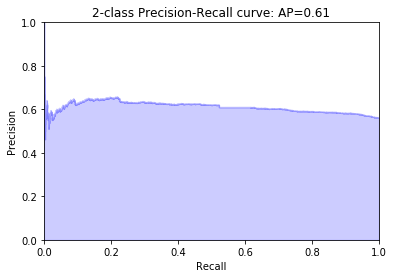

In [8]:
y_score = clf.predict_proba(test_xs).T[1]
average_precision = average_precision_score(test_ys, y_score, pos_label = 'up')
print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))
precision, recall, thresholds = precision_recall_curve(test_ys, y_score, pos_label = 'up')
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

In [9]:
probabilities = clf.predict_proba(test_xs).T[1]
np.mean(probabilities), np.std(probabilities)

(0.5079234787204905, 0.038875439086021056)

***Statistical Tests of Model Performance***

In [10]:
#Statistical tests for mid-term trading
up_prec_random = np.array([0.5/1.01, 0.49, 0.54/1.04, 0.55/1.05, 0.52/1.02, 0.5])
up_prec_always_up = np.array([843/1332, 845/1333, 639/1332, 1165/1333, 1134/1332, 471/1333])
up_prec_trend = np.array([0.67/1.08, 0.61/1.06, 0.58/0.96, 0.74/1.21, 0.63/1.08, 0.57/0.9])
up_prec_svc = np.array([0.71/1.13, 0.31/0.54, 0.55/0.93, 0.54/0.95, 0.61, 0.74/1.03])
print("result for up precisions against always up:", stats.kruskal(up_prec_always_up, up_prec_svc)) 
print("result for up precisions against random:", stats.kruskal(up_prec_random, up_prec_svc)) 
print("result for up precisions against trend:", stats.kruskal(up_prec_trend, up_prec_svc)) 
print(" ")

down_prec_random = np.array([0.5/0.99, 0.51, 0.5/0.96, 0.5/0.95, 0.5/0.98, 0.5])
down_prec_always_down = np.array([489/1332, 488/1333, 693/1332, 168/1333, 198/1332, 862/1333])
down_prec_trend = np.array([0.58/0.84, 0.77/1.46, 0.62/1.04, 0.53/0.79, 0.55/0.92, 0.67/1.1])
down_prec_svc = np.array([0.6/0.84, 0.77/1.56, 0.62/1.07, 0.59/1.05, 0.61, 0.71/0.97])
print("result for down precisions against always down:", stats.kruskal(down_prec_always_down, down_prec_svc)) 
print("result for down precisions against random:", stats.kruskal(down_prec_random, down_prec_svc)) 
print("result for down precisions against trend:", stats.kruskal(down_prec_trend, down_prec_svc)) 
print(" ")
print("*********************************************************************************************************************")
print(" ")

#Statistical tests for short-term trading
up_prec_random = np.array([0.49/0.99, 0.5, 0.52/1.05, 0.5/1.01, 0.51/0.98, 0.51/1.01])
up_prec_always_up = np.array([850/1577, 829/1578, 786/1577, 941/1578, 904/1577, 862/1578])
up_prec_trend = [0.53, 0.53/0.99, 0.49/0.95, 0.57/1.01, 0.53/1.01, 0.56/1.07]
up_prec_svc = np.array([0.57/1.04, 0.61/1.06, 0.61/1.05, 0.46/0.88, 0.54/1.01, 0.46/0.8])
print("result for up precisions against always up:", stats.kruskal(up_prec_always_up, up_prec_svc)) 
print("result for up precisions against random:", stats.kruskal(up_prec_random, up_prec_svc)) 
print("result for up precisions against trend:", stats.kruskal(up_prec_trend, up_prec_svc)) 
print(" ")

down_prec_random = np.array([0.49/1.01, 0.5, 0.47/0.95, 0.49/0.99, 0.53/1.02, 0.5/0.99])
down_prec_always_down = np.array([727/1577, 749/1578, 791/1577, 637/1578, 673/1577, 716/1578])
down_prec_trend = [0.53, 0.54/1.01, 0.54/1.05, 0.56/0.99, 0.53/0.99, 0.49/0.93]
down_prec_svc = np.array([0.53/0.96, 0.55/0.94, 0.56/0.95, 0.58/1.12, 0.53/0.99, 0.66/1.2])
print("result for down precisions against always down:", stats.kruskal(down_prec_always_down, down_prec_svc)) 
print("result for down precisions against random:", stats.kruskal(down_prec_random, down_prec_svc)) 
print("result for down precisions against trend:", stats.kruskal(down_prec_trend, down_prec_svc)) 


result for up precisions against always up: KruskalResult(statistic=0.4102564102564159, pvalue=0.5218393903336124)
result for up precisions against random: KruskalResult(statistic=8.307692307692314, pvalue=0.003947751856903446)
result for up precisions against trend: KruskalResult(statistic=0.1025641025641093, pvalue=0.7487740417065392)
 
result for down precisions against always down: KruskalResult(statistic=4.333333333333336, pvalue=0.0373729883406513)
result for down precisions against random: KruskalResult(statistic=3.6923076923076934, pvalue=0.054663935891675085)
result for down precisions against trend: KruskalResult(statistic=0.0, pvalue=1.0)
 
*********************************************************************************************************************
 
result for up precisions against always up: KruskalResult(statistic=0.4102564102564159, pvalue=0.5218393903336124)
result for up precisions against random: KruskalResult(statistic=8.307692307692314, pvalue=0.003947751856

***Function to make prediction***

In [11]:
def predict(closes, company):
    '''takes FEATURES+MEAN_LENGTH-1 days worth of closes (in a numpy array with the earliest closes first) 
    and the company they are from (one of aapl, goog, fb, ibm, bb, msft, samsung) and predicts the direction 
    over the next DAYS_AHEAD days.'''
  
    closes = np.convolve(closes, np.ones((MEAN_LENGTH,))/MEAN_LENGTH, mode='valid')
    engineered_data = np.array([closes[::JUMP]])
    scaler = scalers[company_indices[company]]
    engineered_data = scaler.transform(engineered_data.astype(np.float))
    engineered_data = pca.transform(engineered_data)
    pred = clf.predict(engineered_data)[0]
    return pred


In [12]:
#Example for short-term trading
predict(np.array([164.13, 162.81, 161.45, 162.29, 167.37, 171.26, 172.51, 169.13, 169.60, 172.07, 171.92]), 'fb')

'down'

***Some visualization with SSA***

In [7]:
ssa = SSA(window_size = 50)
transformed = ssa.fit_transform(data[2].T[4].reshape((1, -1)))
transformed = transformed[0]

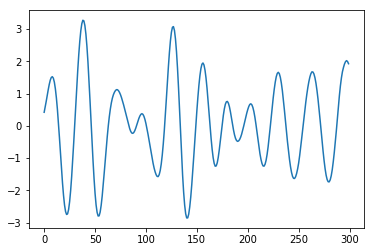

In [8]:
plt.plot(transformed[3][-300:]);

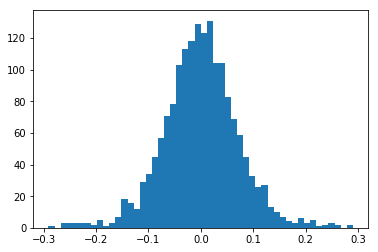

In [9]:
plt.hist(transformed[49], 50);

In [10]:
for i in range(5):
    print(np.std(transformed[i]))

52.545645715977734
2.5162809492807403
1.075143467301402
0.772023780025227
0.6760565178319204


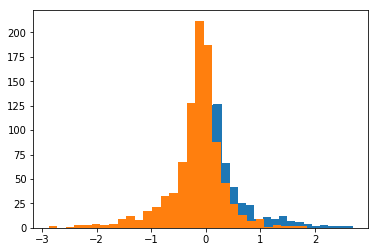

In [11]:
plt.hist([transformed[6][i] for i in range(90,transformed[1].size-7) if data[2].T[4][i] > data[2].T[4][i+7]], 30);
plt.hist([transformed[6][i] for i in range(90,transformed[1].size-7) if data[2].T[4][i] <= data[2].T[4][i+7]], 30);


***An alternate approach: predict only one stock and use the SSA components as features***

In [12]:
ssa = SSA(window_size = 50)
closes = data[2].T[4]
ssa.fit(closes[:int(0.8*closes.size)].reshape((1, -1))) #fit only to train data
transformed = ssa.transform(closes.reshape((1,-1)))[0]

In [66]:
labels = np.array(['down' if closes[i+7] > closes[i] else 'up' for i in range(transformed[1].size-7)])
input_data = transformed[:10].T[:-7]
train_xs, test_xs = input_data[:int(0.8*input_data.shape[0])], input_data[int(0.8*input_data.shape[0]):]
train_ys, test_ys = labels[:int(0.8*input_data.shape[0])], labels[int(0.8*input_data.shape[0]):]

In [67]:
up_number = labels[labels == 'up'].size
clf = GaussianNB(priors = [1 - up_number/labels.size, up_number/labels.size])
clf.fit(train_xs, train_ys)

GaussianNB(priors=[0.5690962099125365, 0.43090379008746355],
      var_smoothing=1e-09)

down pred: 176 up pred: 167
down test: 186 up test: 157
Out of a total of 343 samples, 273 were correct
Normalized confusion matrix
[[0.78494624 0.21505376]
 [0.1910828  0.8089172 ]]


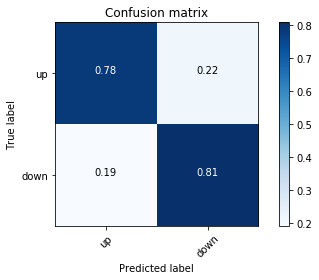

In [68]:
pred = clf.predict(test_xs)
total = test_ys.shape[0]
correct = len([x for x in pred==test_ys if x==True])
print('down pred:', len([i for i in pred if i == 'down']), 'up pred:', len([i for i in pred if i == 'up']))
print('down test:', len([i for i in test_ys if i == 'down']), 'up test:', len([i for i in test_ys if i == 'up']))
print("Out of a total of %d samples, %d were correct" %(total, correct))
cnf_matrix = confusion_matrix(test_ys, pred)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['up', 'down'], normalize=True)

down pred: 196 up pred: 147
down test: 186 up test: 157
Out of a total of 343 samples, 283 were correct
Normalized confusion matrix
[[0.8655914  0.1344086 ]
 [0.22292994 0.77707006]]


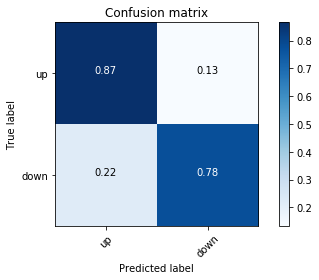

In [69]:
smote = SMOTE(random_state = 1729)
oversampled_xs, oversampled_ys = smote.fit_resample(train_xs, train_ys)
clf2 = svm.SVC(kernel = 'linear', probability = True, random_state = 42)
clf2.fit(oversampled_xs, oversampled_ys)
pred2 = clf2.predict(test_xs)
total = test_ys.shape[0]
correct = len([x for x in pred2==test_ys if x==True])
print('down pred:', len([i for i in pred2 if i == 'down']), 'up pred:', len([i for i in pred2 if i == 'up']))
print('down test:', len([i for i in test_ys if i == 'down']), 'up test:', len([i for i in test_ys if i == 'up']))
print("Out of a total of %d samples, %d were correct" %(total, correct))
cnf_matrix = confusion_matrix(test_ys, pred2)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['up', 'down'], normalize=True)

In [70]:
nb_scores = cross_val_score(clf, input_data, labels, cv = TimeSeriesSplit(n_splits = 20))
print("confidence interval: %f +/- %f" %(np.mean(nb_scores[10:]), 2*np.std(nb_scores[10:])))

confidence interval: 0.735802 +/- 0.168626


In [71]:
class oversample_svc(svm.SVC):
    """svc that oversamples train data before fitting"""
    def fit(self, X, y, sw = None):
        smote = SMOTE(random_state = 1729)
        oversampled_xs, oversampled_ys = smote.fit_resample(X, y)
        super().fit(oversampled_xs, oversampled_ys, sample_weight = sw)


oversample_clf2 = oversample_svc(kernel = 'linear', probability = True, random_state = 42)
svc_scores = cross_val_score(oversample_clf2, input_data, labels, cv = TimeSeriesSplit(n_splits = 20))
print("confidence interval: %f +/- %f" %(np.mean(svc_scores[10:]), 2*np.std(svc_scores[10:])))

confidence interval: 0.772840 +/- 0.097648


In [72]:
nb_scores[10:]

array([0.69135802, 0.67901235, 0.81481481, 0.74074074, 0.74074074,
       0.75308642, 0.85185185, 0.5308642 , 0.7654321 , 0.79012346])

In [73]:
svc_scores[10:]

array([0.67901235, 0.7037037 , 0.79012346, 0.77777778, 0.7654321 ,
       0.74074074, 0.83950617, 0.81481481, 0.80246914, 0.81481481])

In [74]:
probabilities = 1 - clf2.predict_proba(test_xs).T[0] #predicted probability of the stock going up
print(np.mean(probabilities), np.std(probabilities))

0.43767436257458747 0.4105686668649781


In [75]:
print(list(zip(probabilities[:50], test_ys[:50])))

[(0.7664740450883248, 'up'), (0.9376975406929196, 'up'), (0.971742430062235, 'up'), (0.9730148605868058, 'up'), (0.9457944456804601, 'up'), (0.8187082439543093, 'up'), (0.45121086941641275, 'up'), (0.13035723764642082, 'up'), (0.03934685487606615, 'down'), (0.01987507689747048, 'down'), (0.021213239731715516, 'down'), (0.04793471942554017, 'down'), (0.1622663925210298, 'down'), (0.5, 'up'), (0.8169454575617575, 'up'), (0.9312760066155547, 'up'), (0.9564842391128956, 'up'), (0.9452503846204839, 'up'), (0.8728189903152528, 'up'), (0.6269710665184445, 'up'), (0.2361542338780318, 'down'), (0.06176701194845935, 'down'), (0.017380109779578046, 'down'), (0.007916599025338478, 'down'), (0.006963061965396533, 'down'), (0.01223342519093995, 'down'), (0.036582404292254456, 'down'), (0.1263847558631156, 'down'), (0.37986587777658853, 'up'), (0.6852343226059572, 'down'), (0.8501088134483428, 'up'), (0.9019543562043146, 'up'), (0.894589593342071, 'up'), (0.8046166160518637, 'up'), (0.521543469138413